## Keywords - Synthetic Cardiovascular
1. Shapley Flow
2. Independent SHAP
3. Kernel SHAP
4. On Manifold SHAP
5. ASV
6. Causal SHAP
7. The ground truth using Exact SHAP

In [4]:
from shapflow import flow
flow.example_concise() # running the sanity check example in flow.py
import shap
import pickle
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from shapflow import flow
from shapflow.flow import Node, Graph, GraphExplainer
from on_manifold import OnManifoldExplainer, IndExplainer
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
import logging
logging.getLogger("numba").setLevel(logging.WARNING)
logging.getLogger("shap").setLevel(logging.WARNING)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 7951.14it/s]

credit x2->target: [1.]
credit x1->x2: [1.]
credit x1->target: [1.]


### Shapley Flow

In [84]:
data_path = '../../dataset/Synthetic_Cardiovascular.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, n_jobs=-1, random_state=42)

bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 4425.40it/s]
DEBUG:graphviz.backend.execute:run [WindowsPath('dot'), '-Kdot', '-Tsvg']


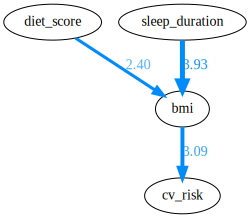

In [85]:
diet_score = Node('diet_score')
sleep_duration = Node('sleep_duration')

bmi = Node(
    'bmi',
    lambda diet_score, sleep_duration: 0.940100 * diet_score + 0.815536 * sleep_duration,
    [diet_score, sleep_duration]
)
mental_health = Node(
    'mental_health',
    lambda bmi: 0.962941 * bmi,
    [bmi]
)
cv_risk = Node(
    'cv_risk',
    lambda bmi: 0.869748 * bmi,
    [bmi],
    is_target_node=True
)

graph = Graph([diet_score, sleep_duration, bmi, mental_health, cv_risk])

bg_sample = pd.DataFrame([X_train[['diet_score', 'sleep_duration', 'bmi', 'mental_health']].mean()])
cv_risk_pct = np.quantile(y_test, 0.975)
fg_idx = np.where(y_test >= cv_risk_pct)[0]
fg_sample = pd.DataFrame(X_test.iloc[fg_idx][['diet_score', 'sleep_duration', 'bmi', 'mental_health']])

graph_explainer = GraphExplainer(graph, bg_sample)

shapley_flow_results = graph_explainer.shap_values(fg_sample)
shapley_flow_results.draw()
print(shapley_flow_results)

### Independent SHAP

In [87]:
bg = pd.DataFrame([X_train[['diet_score', 'sleep_duration', 'bmi', 'mental_health']].mean()])
cv_risk_pct = np.quantile(y_test, 0.975)
fg_idx = np.where(y_test >= cv_risk_pct)[0]
fg = pd.DataFrame(X_test.iloc[fg_idx][['diet_score', 'sleep_duration', 'bmi', 'mental_health']])

cf_ind = IndExplainer(rf.predict, bg, silent=True).shap_values(fg)

print(cf_ind.values.mean(axis=0))

[[-0.55455185]
 [ 0.11238388]
 [ 4.11719916]
 [ 1.58347566]]


### Kernel SHAP

In [88]:
background_data = shap.kmeans(X_train, 100)
explainer = shap.KernelExplainer(rf.predict, background_data)
shap_values = explainer.shap_values(fg)

print(shap_values.mean(axis=0))

100%|██████████| 5/5 [00:00<00:00, 13.35it/s]

[-0.19103551  0.32472964  4.29961124  1.70327164]


### On Manifold SHAP

In [89]:
cf_onm = OnManifoldExplainer(rf.predict, pd.concat([bg, fg]), silent=True).shap_values(fg)
print(cf_onm.values.mean(axis=0))

[[1.30732159]
 [1.18623131]
 [1.38113973]
 [1.38381422]]


### ASV

In [90]:
# ASV: restricting the order of on manifold methods
cf_asv = OnManifoldExplainer(rf.predict, pd.concat([bg, fg]), orderings=[[2, 0, 1, 3]], silent=True).shap_values(fg)
print(cf_asv.values.mean(axis=0))

[[0.02880139]
 [0.04011717]
 [4.90546791]
 [0.28412039]]


### Exact SHAP Explainer

In [91]:
data_path = '../../dataset/Synthetic_Cardiovascular.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk', 'bmi','mental_health'])
y = df['cv_risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )
rf.fit(X_train, y_train)

bg = pd.DataFrame([X_train[['diet_score', 'sleep_duration']].mean()])
cv_risk_pct = np.quantile(y_test, 0.975)
fg_idx = np.where(y_test >= cv_risk_pct)[0]
fg = pd.DataFrame(X_test.iloc[fg_idx][['diet_score', 'sleep_duration']])

explainer = shap.ExactExplainer(rf.predict, X_train)

exact_reduced_shap_values = explainer(fg)

print(exact_reduced_shap_values.values.mean(axis=0))

[0.55260416 3.63623654]


### Causal SHAP

In [92]:
file_path = '../../result/R/Causal_SHAP_CV_42_Dec.pkl'
def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

data_path = '../../dataset/Synthetic_Cardiovascular.csv'
df = pd.read_csv(data_path)

X = df.drop(columns=['cv_risk'])
y = df['cv_risk']
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

causal_shap_values = load_and_format_shap_values(file_path, feature_names)

print(causal_shap_values[fg_idx].mean(axis=0))

[0.23971002 2.24168088 3.60565293 0.        ]
